# Multi-modal data with a GraphQL alternative

This notebook will demonstrate working with multi-modal or multi-source data. By default, Hyrax assumes only a single dataset will be used for a given model.

As before, the two required configuration parameters are `['data_location']` (to define the location of the data) and `['dataset_class']` (to define the dataset class that will load specific data from disk).

Below we the standard approach of loading the default dataset defined in the Hyrax config using `h.prepare()`. We then print the dataset object to see the basic information about it.

In [1]:
from hyrax import Hyrax

h = Hyrax()

# Set a few configs for later use
h.config["train"]["epochs"] = 1
h.set_config("model.name", "HyraxAutoencoder")
h.set_config(
    "data_request",
    {
        "train": {
            "data": {
                "dataset_class": "HyraxRandomDataset",
                "primary_id_field": "object_id",
                "dataset_config": {"shape": (1, 32, 32), "size": 50000},
            },
        },
    },
)

/Users/derekjones/envs/hyrax/lib/python3.13/site-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


[2026-02-20 12:17:45,680 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.


[2026-02-20 12:17:45,680 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.


[2026-02-20 12:17:45,681 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.lr_scheduler.ExponentialLR.


[2026-02-20 12:17:50,210 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.


[2026-02-20 12:17:50,220 hyrax.config_utils:WARNING] Configuration for 'data_request' failed Pydantic validation and will be used as-is. This may indicate missing required fields (e.g., 'primary_id_field') or invalid structure. Validation error: 2 validation errors for DataRequestDefinition
train.DataRequestConfig.data_location
  Field required [type=missing, input_value={'dataset_class': 'HyraxR...32, 32), 'size': 50000}}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing
train.dict[str,DataRequestConfig].data.data_location
  Field required [type=missing, input_value={'dataset_class': 'HyraxR...32, 32), 'size': 50000}}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing


[2026-02-20 12:17:50,220 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.


[2026-02-20 12:17:50,221 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.


[2026-02-20 12:17:50,221 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.lr_scheduler.ExponentialLR.


[2026-02-20 12:17:50,221 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.


[2026-02-20 12:17:50,226 hyrax.config_utils:WARNING] Runtime config contains key or section 'data_request' which has no default defined. All configuration keys and sections must be defined in /Users/derekjones/code/work/hyrax/src/hyrax/hyrax_default_config.toml


In [2]:
ds = h.prepare()["train"]
print(ds)

[2026-02-20 12:17:52,489 hyrax.prepare:INFO] Finished Prepare


Name: data (primary dataset)
  Dataset class: HyraxRandomDataset
  Primary ID field: object_id
  Requested fields: image, label, meta_field_1, meta_field_2, object_id
  Dataset config:
    shape: [1, 32, 32]
    size: 50000



## Pass the data through ``prepare_inputs``
Since we have access to the model class, we can call the ``prepare_inputs`` method with example data.
This allows easy checking that the output matches the expectations of the model architecture.

In this example, we expect ``prepare_inputs`` to return a tuple of (numpy.array, int), or specifically a multi-channel image and a label.

In [3]:
samp = ds[2335]
print(samp)
m = h.model()
res = m.prepare_inputs(samp)
print(f"Type and shape of resulting image: {type(res[0])}, {res[0].shape}")

{'data': {'image': array([[[0.9993206 , 0.24844742, 0.07472038, ..., 0.19890529,
         0.6762412 , 0.2656371 ],
        [0.26220918, 0.305416  , 0.83473223, ..., 0.00641263,
         0.21008873, 0.7148612 ],
        [0.8158195 , 0.7323841 , 0.13330418, ..., 0.81598246,
         0.2337833 , 0.3971014 ],
        ...,
        [0.41137224, 0.40423387, 0.19257122, ..., 0.34238744,
         0.58312994, 0.7775264 ],
        [0.3764146 , 0.6264323 , 0.28519917, ..., 0.14582026,
         0.93530905, 0.5605867 ],
        [0.75328624, 0.73888373, 0.36882102, ..., 0.8995268 ,
         0.3712474 , 0.03462631]]], shape=(1, 32, 32), dtype=float32), 'label': np.int64(0), 'meta_field_1': np.float64(23832.5), 'meta_field_2': np.float64(15888.333333333334), 'object_id': '2388'}, 'object_id': '2388'}
Type and shape of resulting image: <class 'numpy.ndarray'>, (32, 32)


## Defining the data request specification
The following shows a way to request new datasets. For this example, we'll use a contrived scenario were we want two instances of cifar images from the `HyraxCifarDataset` in addition to a random image from the `HyraxRandomDataset`.

We can directly modify the loaded configuration using `h.config["data_request"]`

In [4]:
h.set_config(
    "data_request",
    {
        "train": {
            "cifar_0": {
                "dataset_class": "HyraxCifarDataset",
                "data_location": "./data",
                "fields": ["object_id", "image", "label"],
                "primary_id_field": "object_id",
            },
            "cifar_1": {
                "dataset_class": "HyraxCifarDataset",
                "data_location": "./data",
                "fields": ["image", "label"],
            },
            "random": {
                "dataset_class": "HyraxRandomDataset",
                "data_location": "./data",
                "fields": ["image"],
                "dataset_config": {
                    "seed": 4200,
                    "size": 50000,  # must match the primary in length
                    "shape": [1, 32, 32],  # and shape
                },
            },
        },
        "infer": {
            "cifar_0": {
                "dataset_class": "HyraxCifarDataset",
                "data_location": "./data",
                "fields": ["object_id", "image", "label"],
                "primary_id_field": "object_id",
            },
            "cifar_1": {
                "dataset_class": "HyraxCifarDataset",
                "data_location": "./data",
                "fields": ["image", "label"],
            },
            "random": {
                "dataset_class": "HyraxRandomDataset",
                "data_location": "./data",
                "fields": ["image"],
                "dataset_config": {
                    "seed": 4200,
                    "size": 50000,  # must match the primary in length
                    "shape": [1, 32, 32],  # and shape
                },
            },
        },
    },
)

[2026-02-20 12:17:52,577 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.


[2026-02-20 12:17:52,578 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.


[2026-02-20 12:17:52,578 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.lr_scheduler.ExponentialLR.


[2026-02-20 12:17:52,578 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.


[2026-02-20 12:17:52,585 hyrax.config_utils:WARNING] Runtime config contains key or section 'cifar_0' which has no default defined. All configuration keys and sections must be defined in /Users/derekjones/code/work/hyrax/src/hyrax/hyrax_default_config.toml


[2026-02-20 12:17:52,585 hyrax.config_utils:WARNING] Runtime config contains key or section 'cifar_1' which has no default defined. All configuration keys and sections must be defined in /Users/derekjones/code/work/hyrax/src/hyrax/hyrax_default_config.toml


[2026-02-20 12:17:52,586 hyrax.config_utils:WARNING] Runtime config contains key or section 'random' which has no default defined. All configuration keys and sections must be defined in /Users/derekjones/code/work/hyrax/src/hyrax/hyrax_default_config.toml


[2026-02-20 12:17:52,586 hyrax.config_utils:WARNING] Runtime config contains key or section 'infer' which has no default defined. All configuration keys and sections must be defined in /Users/derekjones/code/work/hyrax/src/hyrax/hyrax_default_config.toml


When experimentation is complete, the preceding can be specified directly in a configuration .toml file like so:

```toml
[data_request]
[data_request.cifar_0]
dataset_class = "HyraxCifarDataset"
data_location = "./data"
fields = ["object_id", "image", "label"]
primary_id_field = "object_id"

[data_request.cifar_1]
dataset_class = "HyraxCifarDataset"
data_location = "./data"
fields = ["image"]

[data_request.random]
dataset_class = "HyraxRandomDataset"
data_location = "./data"
fields = ["image"]
[data_request.rando.dataset_config]
seed = 4200
```

## Examine the multimodal dataset
As before, calling ``h.prepare()`` will return an instance of the ``DataProvider`` dataset.
The ``DataProvider`` class can be thought of as a container of multiple datasets, as well as a gateway (in GraphQL terminology)
that will send requests for specific data to the datasets it contains. Printing the dataset object will show the configuration of the dataset.

In [5]:
ds = h.prepare()["train"]
print(ds)

[2026-02-20 12:18:06,191 hyrax.prepare:INFO] Finished Prepare


Name: data
  Dataset class: HyraxRandomDataset
  Primary ID field: object_id
  Requested fields: image, label, meta_field_1, meta_field_2, object_id
  Dataset config:
    shape: [1, 32, 32]
    size: 50000
Name: cifar_0 (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: object_id, image, label
Name: cifar_1
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, label
Name: random
  Dataset class: HyraxRandomDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image
  Dataset config:
    seed: 4200
    size: 50000
    shape: [1, 32, 32]



In [6]:
ds.metadata_fields()

['object_id_data',
 'meta_field_1_data',
 'meta_field_2_data',
 'label_cifar_0',
 'object_id_cifar_0',
 'label_cifar_1',
 'object_id_cifar_1',
 'object_id_random',
 'meta_field_1_random',
 'meta_field_2_random',
 'object_id']

In [7]:
ds.metadata(idxs=[0, 1, 2, 4, 5], fields=["label_cifar_0", "label_cifar_1", "meta_field_1_random"])

array([(6, 6, 25000. ), (9, 9, 24999.5), (9, 9, 24999. ), (1, 1, 24998. ),
       (1, 1, 24997.5)],
      dtype=[('label_cifar_0', '<i8'), ('label_cifar_1', '<i8'), ('meta_field_1_random', '<f8')])

The various datasets contained within the `DataProvider` instance.

In [8]:
ds.prepped_datasets

{'data': <hyrax.data_sets.random.hyrax_random_dataset.HyraxRandomDataset at 0x1277eda90>,
 'cifar_0': <hyrax.data_sets.hyrax_cifar_dataset.HyraxCifarDataset at 0x1277be660>,
 'cifar_1': <hyrax.data_sets.hyrax_cifar_dataset.HyraxCifarDataset at 0x1206ef250>,
 'random': <hyrax.data_sets.random.hyrax_random_dataset.HyraxRandomDataset at 0x127a1d810>}

In [9]:
print(f"Is iterable: {ds.is_iterable()}")  # Should return False
print(f"Is mappable: {ds.is_map()}")  # Should return True

Is iterable: False
Is mappable: True


Checking the length of the dataset is the same as always.

In [10]:
print(f"Length of the multimodal dataset: {len(ds)}")
print(f"Length of a specific dataset contained inside: {len(ds.prepped_datasets['cifar_0'])}")

Length of the multimodal dataset: 50000
Length of a specific dataset contained inside: 50000


In [11]:
samp = ds[2335]
print("Fields from cifar_0")
print(samp["cifar_0"]["image"].shape)
print(samp["cifar_0"]["label"])
print(samp["cifar_0"]["object_id"])
print("Fields from cifar_1")
print(samp["cifar_1"]["image"].shape)
print(samp["cifar_1"]["label"])
print("Fields from random")
print(samp["random"]["image"].shape)

Fields from cifar_0
(3, 32, 32)
5
02335
Fields from cifar_1
(3, 32, 32)
5
Fields from random
(1, 32, 32)


## Updating ``prepare_inputs``
The default implementation of ``prepare_inputs`` only makes use of "cifar_0" and "rando".
But if we are experimenting, we don't want to have to make code changes in the model class.
It would be much easier to experiment with in the notebook.
Here, we redefine the ``prepare_inputs`` method, and check the results by running sample data through the method.

In [12]:
import torch


@staticmethod
def prepare_inputs(data_dict):
    """This function converts structured data to the input data we need to run

    Parameters
    ----------
    data_dict : dict
        The dictionary returned from our data source
    """
    import numpy as np

    cifar_data = data_dict.get("cifar_0", {})
    random_data = data_dict.get("random", {})
    more_cifar_data = data_dict.get("cifar_1", {})

    # Get the image data from each dataset
    cifar_image = cifar_data["image"]
    random_image = random_data["image"]
    more_cifar_image = more_cifar_data["image"]

    stack_dim = 0 if cifar_image.ndim == 3 else 1

    # Stack the images together to produce a single 7 channel image.
    image = np.concatenate([cifar_image, random_image, more_cifar_image], axis=stack_dim)

    return image


m.prepare_inputs = prepare_inputs

After running the same sample through as before, we can see that the number of channels
in the image has changed (from 4 to 7), while all the other values have remained the same.

In [13]:
new_res = m.prepare_inputs(samp)
print(f"Type and shape of resulting 0th layer of the image: {type(new_res[0])}, {new_res[0].shape}")
print(f"Type and shape of the 1st layer of the image: {type(new_res[1])}, {new_res[1].shape}")
print(f"Overall shape of the returned image: {new_res.shape}")

Type and shape of resulting 0th layer of the image: <class 'numpy.ndarray'>, (32, 32)
Type and shape of the 1st layer of the image: <class 'numpy.ndarray'>, (32, 32)
Overall shape of the returned image: (7, 32, 32)


## Train with this model
Now that we've seen that the ``prepare_inputs`` method is returning a reasonable form of data, we can train our model.
As before, we call ``h.train()``.
While it is quiet verbose, the initialization logging shows that the model instance is created with data from
the ``DataProvider`` class, and that our new implementation of ``prepare_inputs`` is being used to manipulate
the data from ``DataProvider`` into the a form that our model architecture accepts.

In [14]:
h.train()

[2026-02-20 12:18:20,106 hyrax.models.model_registry:INFO] Setting model's self.optimizer from config: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.


[2026-02-20 12:18:20,106 hyrax.models.model_registry:INFO] Setting model's self.criterion from config: torch.nn.CrossEntropyLoss with default arguments.


[2026-02-20 12:18:20,106 hyrax.models.model_registry:INFO] Setting model's self.scheduler from config: torch.optim.lr_scheduler.ExponentialLR
with arguments: {'gamma': 1}.


[2026-02-20 12:18:20,107 hyrax.verbs.train:INFO] Training model: HyraxAutoencoder


[2026-02-20 12:18:20,107 hyrax.verbs.train:INFO] Training dataset(s):
{'train': Name: data
  Dataset class: HyraxRandomDataset
  Primary ID field: object_id
  Requested fields: image, label, meta_field_1, meta_field_2, object_id
  Dataset config:
    shape: [1, 32, 32]
    size: 50000
Name: cifar_0 (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: object_id, image, label
Name: cifar_1
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, label
Name: random
  Dataset class: HyraxRandomDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image
  Dataset config:
    seed: 4200
    size: 50000
    shape: [1, 32, 32]
, 'infer': Name: cifar_0 (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: object_id, image, label
Name: cifar_1
  Dataset class: Hyrax

2026-02-20 12:18:20,137 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Name: data
  Dataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x12833eba0>, 'batch_size': 512, 'shuffle': False, 'collate_fn': <bound method DataProvider.collate of Name: data
  Dataset class: HyraxRandomDataset
  Primary ID field: object_id
  Requested fields: image, label, meta_field_1, meta_field_2, object_id
  Dataset config:
    shape: [1, 32, 32]
    size: 50000
Name: cifar_0 (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: object_id, image, label
Name: cifar_1
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, label
Name: random
  Dataset class: HyraxRandomDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image
  Dataset config:
    seed: 4200
    size: 50000
    shape: [1

2026-02-20 12:18:20,138 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Name: data
  Dataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x127a1f750>, 'batch_size': 512, 'shuffle': False, 'collate_fn': <bound method DataProvider.collate of Name: data
  Dataset class: HyraxRandomDataset
  Primary ID field: object_id
  Requested fields: image, label, meta_field_1, meta_field_2, object_id
  Dataset config:
    shape: [1, 32, 32]
    size: 50000
Name: cifar_0 (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: object_id, image, label
Name: cifar_1
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, label
Name: random
  Dataset class: HyraxRandomDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image
  Dataset config:
    seed: 4200
    size: 50000
    shape: [1

/Users/derekjones/envs/hyrax/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/20 12:18:20 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.


2026/02/20 12:18:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


  2%|1         | 1/59 [00:00<?, ?it/s]

[2026-02-20 12:18:47,375 hyrax.pytorch_ignite:INFO] Total training time: 27.08[s]


2026/02/20 12:18:47 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...


2026/02/20 12:18:47 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


[2026-02-20 12:18:47,389 hyrax.verbs.train:INFO] Finished Training


HyraxAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(7, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=64, bias=True)
  )
  (dec_linear): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): GELU(approximate='none')
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate='none')
    (2): 

In [15]:
h.infer()

[2026-02-20 12:19:04,262 hyrax.models.model_registry:INFO] Setting model's self.optimizer from config: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.


[2026-02-20 12:19:04,262 hyrax.models.model_registry:INFO] Setting model's self.criterion from config: torch.nn.CrossEntropyLoss with default arguments.


[2026-02-20 12:19:04,263 hyrax.models.model_registry:INFO] Setting model's self.scheduler from config: torch.optim.lr_scheduler.ExponentialLR
with arguments: {'gamma': 1}.


[2026-02-20 12:19:04,263 hyrax.verbs.infer:INFO] Inference model: HyraxAutoencoder


[2026-02-20 12:19:04,263 hyrax.verbs.infer:INFO] Inference dataset(s):
{'train': Name: data
  Dataset class: HyraxRandomDataset
  Primary ID field: object_id
  Requested fields: image, label, meta_field_1, meta_field_2, object_id
  Dataset config:
    shape: [1, 32, 32]
    size: 50000
Name: cifar_0 (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: object_id, image, label
Name: cifar_1
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, label
Name: random
  Dataset class: HyraxRandomDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image
  Dataset config:
    seed: 4200
    size: 50000
    shape: [1, 32, 32]
, 'infer': Name: cifar_0 (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: object_id, image, label
Name: cifar_1
  Dataset class: Hyra

2026-02-20 12:19:04,264 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Name: cifar_0 (prima': 
	{'sampler': None, 'batch_size': 512, 'shuffle': False, 'collate_fn': <bound method DataProvider.collate of Name: cifar_0 (primary dataset)
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: object_id, image, label
Name: cifar_1
  Dataset class: HyraxCifarDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image, label
Name: random
  Dataset class: HyraxRandomDataset
  Data location: ./data
  Primary ID field: object_id
  Requested fields: image
  Dataset config:
    seed: 4200
    size: 50000
    shape: [1, 32, 32]
>, 'pin_memory': False}


[2026-02-20 12:19:04,276 hyrax.models.model_utils:INFO] Updated config['infer']['model_weights_file'] to: /Users/derekjones/code/work/hyrax/docs/pre_executed/results/20260220-121806-train-Ffgs/example_model.pth


[2026-02-20 12:19:04,277 hyrax.verbs.infer:INFO] Saving inference results at: /Users/derekjones/code/work/hyrax/docs/pre_executed/results/20260220-121847-infer-2jga


[2026-02-20T20:19:04Z WARN  lance::dataset::write::insert] No existing dataset at /Users/derekjones/code/work/hyrax/docs/pre_executed/results/20260220-121847-infer-2jga/lance_db/results.lance, it will be created


  1%|1         | 1/98 [00:00<?, ?it/s]

[2026-02-20 12:19:31,361 hyrax.pytorch_ignite:INFO] Total evaluation time: 27.07[s]


[2026-02-20 12:19:31,362 hyrax.data_sets.result_dataset:INFO] Optimizing Lance table after 98 batches


[2026-02-20 12:19:31,400 hyrax.data_sets.result_dataset:INFO] Lance table optimization complete


[2026-02-20 12:19:31,401 hyrax.verbs.infer:INFO] Inference Complete.


In [16]:
h.umap()

[2026-02-20 12:19:31,468 hyrax.verbs.umap:INFO] Saving UMAP results to /Users/derekjones/code/work/hyrax/docs/pre_executed/results/20260220-121931-umap-PqBG


[2026-02-20 12:19:31,535 hyrax.verbs.umap:INFO] Fitting the UMAP


[2026-02-20 12:19:35,668 hyrax.verbs.umap:INFO] Saving fitted UMAP Reducer


Creating lower dimensional representation using UMAP::   0%|          | 0/98 [00:00<?, ?it/s]

[2026-02-20T20:19:37Z WARN  lance::dataset::write::insert] No existing dataset at /Users/derekjones/code/work/hyrax/docs/pre_executed/results/20260220-121931-umap-PqBG/lance_db/results.lance, it will be created


[2026-02-20 12:20:24,764 hyrax.data_sets.result_dataset:INFO] Optimizing Lance table after 98 batches


[2026-02-20 12:20:24,794 hyrax.data_sets.result_dataset:INFO] Lance table optimization complete


[2026-02-20 12:20:24,795 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP


[2026-02-20 12:20:25,825 hyrax.verbs.visualize:INFO] UMAP directory not specified at runtime. Reading from config values.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
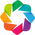

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Points   [x,y]
   .DynamicMap.II :DynamicMap   []
      :Table   [object_id]   (x,y,meta_field_1_random,meta_field_2_random)

In [17]:
h.config["visualize"]["fields"] = ["meta_field_1_random", "meta_field_2_random"]
v = h.visualize()